<a href="https://colab.research.google.com/github/jimmy-pink/computer-science-manual/blob/main/Database%20Middleware/Mysql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MYSQL架构

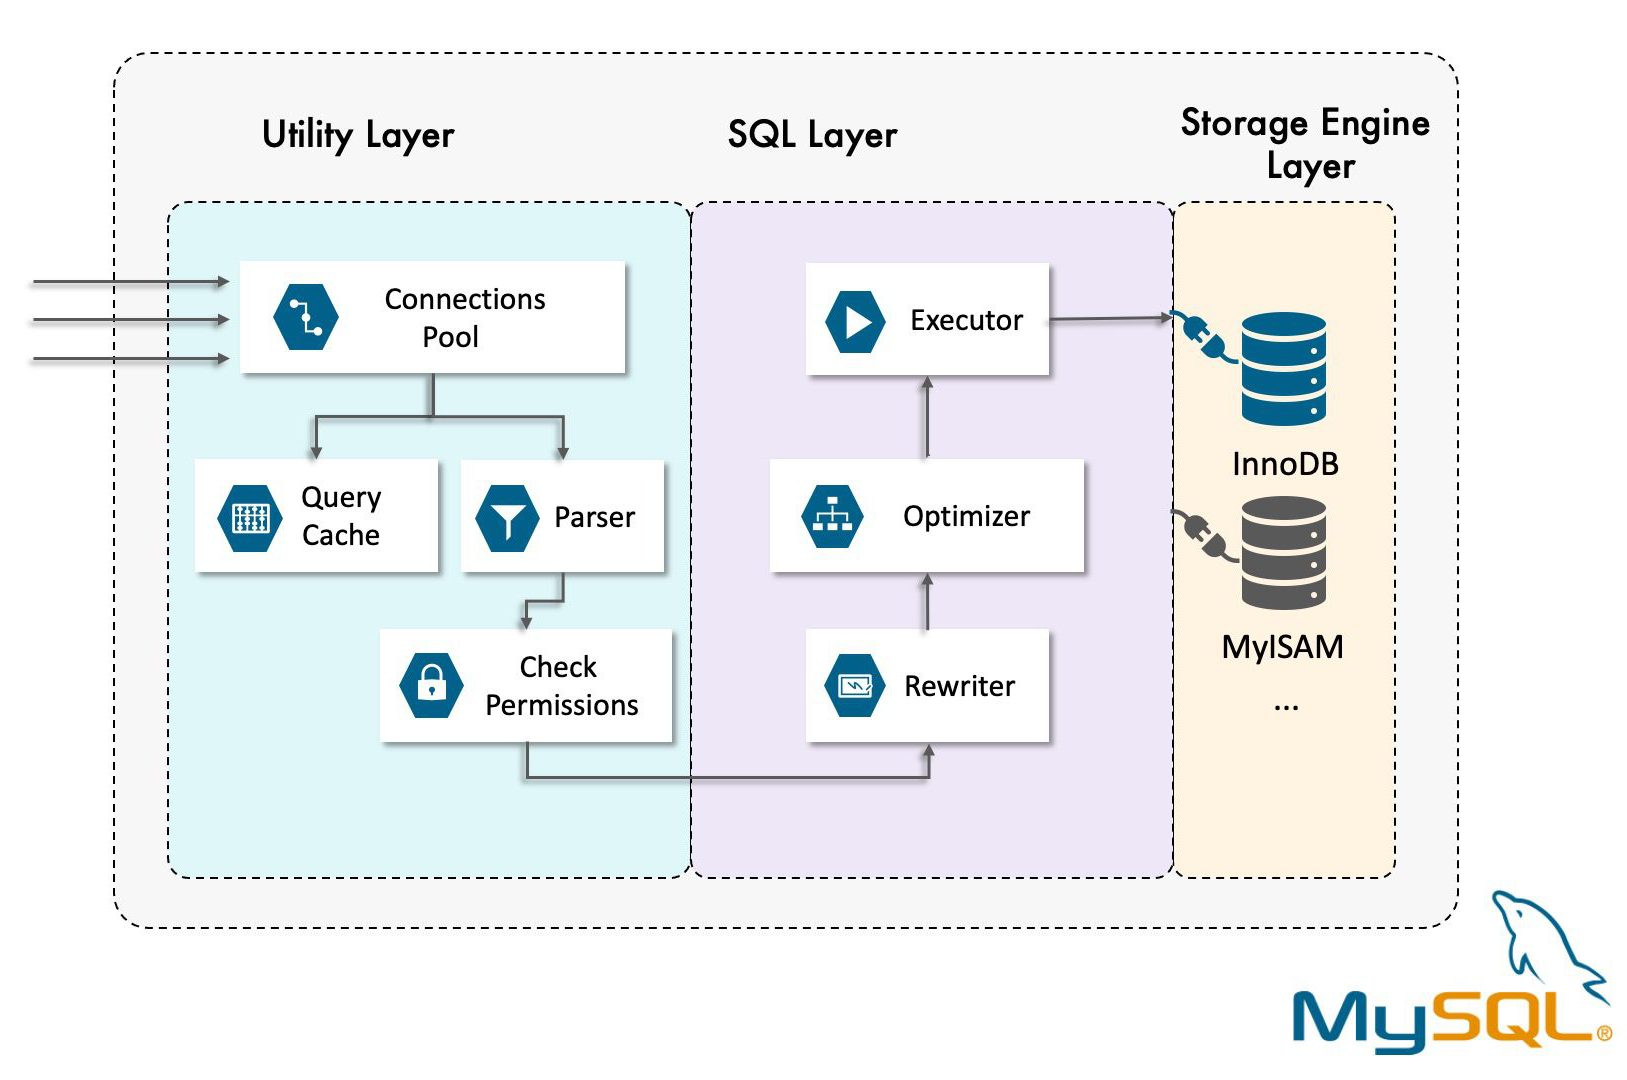

**Connector** 连接器，处理连接请求， 管理连接 和验证身份。

**Query Cache**  
MySQL 8.0以后移除了QueryCache，原因有：  
- 在高并发写场景下性能不佳
- 使用了Global Mutex(全局锁)，高并发场景下严重阻碍性能
- 现代高速缓存，如Redis, 应用本地缓存完全可以替代

**Parser** 语法和词法分析。   
**Preprocessor** 验证表名，列表，和crud权限。  
**Optimizer** 生成最优执行计划，包括索引选择，表顺序，连接类型
- ReWriter : 等价转换，子查询优化， 谓词下推

## 日志系统

### Redo Log
实现原理：WAL( Writting Ahead Logging ).   
- 先写日志，再更新数据页
- 崩溃恢复  crash_safe
- 避免频繁磁盘随机io写 (redo log是磁盘顺序io)      

#### 存储
4个1GB文件顺序、循环写。  
- write pos 当前写入位置
- checkpoint 检查点，此前的空间已被同步到数据页

```text
[ checkpoint ] -----> (已写未刷盘) -----> [ write pos ] -----> (可用空间) -----> [ checkpoint ]
```

#### Buffer Pool
新数据 依靠 **Buffer Pool** 来读取。  
该BufferPool是Mysql进程管理的 直接内存缓冲区。   


#### 数据脏页
| 步骤 | 操作                              | 说明                                     |
|:----:|:----------------------------------|:------------------------------------------|
| 1     | `UPDATE` 语句触发                 | 修改数据时并**未立即写入磁盘**             |
| 2     | 数据页加载至 `Buffer Pool`         | 如果数据页已在 `Buffer Pool`，跳过此步        |
| 3     | 数据页被更新，标记为 `Dirty Page`  | 数据页头部标记为dirty，**尚未写回磁盘**               |
| 4     | `Redo Log` 写入并刷盘               | redo log的**持久化**，即便 `Dirty Page` 尚未落盘 |
| 5     | 事务提交                           | 提交成功，数据仍仅在 `Buffer Pool` 中           |
| 6     | `Checkpoint` 触发，刷回数据页        | `Dirty Page` 被写回磁盘，标记为 `Clean Page` |


### Undo Log
主要用途：   
- 事务回滚
- MVCC版本控制



### Binlog


**Binlog写入流程**   
简单来说， 事务提交前会写binlog到文件，事务提交 binlog周期性刷盘。
  

| **步骤** | **操作**                                          | **详细描述**                                                                                                                                                                  |
|----------|---------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1        | 执行 `UPDATE` 语句                                 | 客户端发送 `UPDATE` 语句到 MySQL 服务器，MySQL 解析 SQL 语句并进行优化，选择执行计划。                                                                                       |
| 2        | 修改数据页（Buffer Pool 中）                       | MySQL 根据执行计划更新相应的数据页。此时数据页标记为 **Dirty**，但尚未写入磁盘（仅在内存中修改）。                                                                               |
| 3        | 生成 Binlog 事件                                 | MySQL 会生成一个 **Binlog 事件**，记录这个 `UPDATE` 操作。事件中包含更新的表、更新的字段、修改的记录等信息。根据 Binlog 格式（行式、语句式或混合式）记录不同的内容。 |
| 4        | 写 Binlog 事件到 Binlog 文件                      | 生成的 **Binlog 事件** 会被写入到 MySQL 的 Binlog 文件中，事件被追加到当前的 Binlog 文件末尾。                                                                                 |
| 5        | 提交事务（如果存在事务）                         | 如果 `UPDATE` 语句是在一个事务中，只有在事务 **提交** 时，Binlog 中的事件才会被永久写入并生效。                                                                            |
| 6        | 刷新 Binlog 到磁盘                                | MySQL 会周期性地将 Binlog 刷新到磁盘，保证数据的持久性。                                                                                                                    |
| 7        | 数据页刷新到磁盘（异步）                         | 数据页标记为 **Dirty**，但在某些情况下，数据页的内容不会立即写入磁盘，而是通过 **后台刷盘机制** 异步写入磁盘，直到刷新操作发生。                                               |
| 8        | Binlog 被从服务器同步（如果启用了复制）           | 如果是主从复制架构，主服务器的 Binlog 会被从服务器读取并执行，保证数据同步。MQ消息也是这一步发出的。                                                                                                |

## 事务


### ACID
- 原子性  要么都成功， 要么都失败
- 一致性  数据完整性和状态有效性。（数据不能凭空产生或消失）
- 隔离性  不同事务之间不会相互影响
- 永久性  一旦提交永久有效

### 隔离级别
- Read Uncommitted
- Read Committed （读已提交， 不可重复读）
- Repeated Read (重复读)
- Serialize 表锁，所有对该表的访问都会一个一个的执行。

幻读： 第二次执行相同的sql，比第一次多读或少读了几行数据。  
开启mybatis缓存时，即使是read committed也可以重复读，因为读到的是缓存。    

| 隔离级别         | 脏读 (Dirty Read) | 不可重复读 (Non-repeatable Read) | 幻读 (Phantom Read) | 性能       |
|-----------------|------------------|----------------------------------|---------------------|------------|
| **读未提交**     | ✅                | ✅                                | ✅                   | 最快       |
| **读已提交**     | ❌                | ✅                                | ✅                   | 较快       |
| **可重复读**     | ❌                | ❌                                | ✅                   | 较慢       |
| **串行化**       | ❌                | ❌                                | ❌                   | 最慢       |

### 事务的传播行为
- 存在加入， 不存在新建
- 存在事务则，不存在则以非事务环境运行
- 当前非事务，抛出异常
- 始终以新事务运行
- 始终在非事务运行，存在事务则抛出异常
- 有事务，以子事务运行；没有且新建

### MVCC实现原理
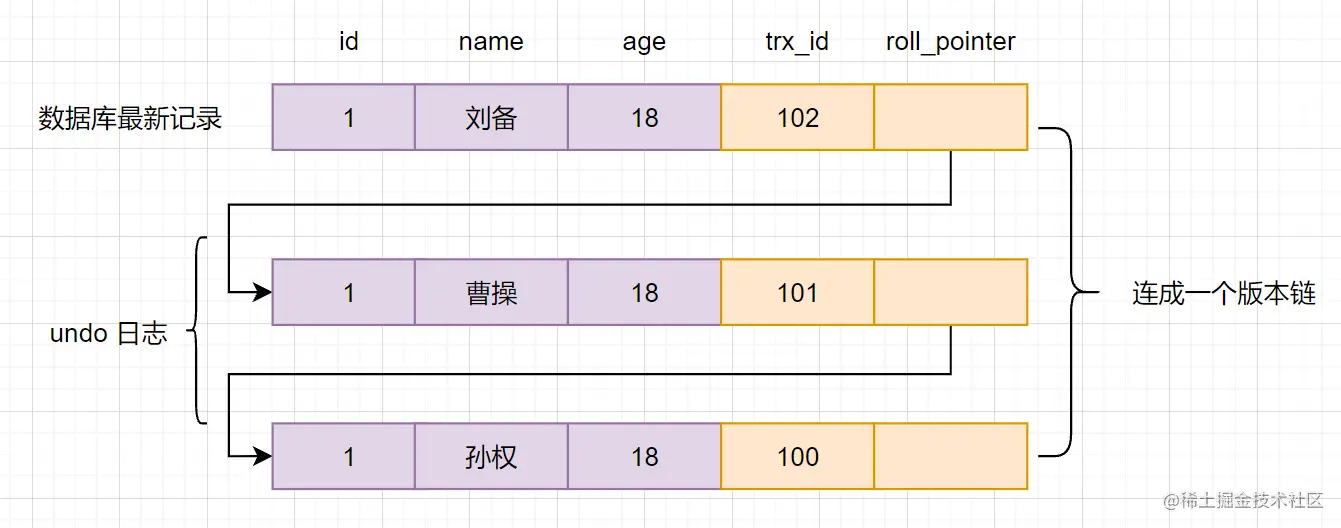

**快照读 和 当前读**
- 快照读  事务开启时，会将数据
- 当前读 写数据前，会读取最新的数据版本

**多版本是如何存储的**  
事务id + 版本号 + 数据行id + 数据值。
多版本之间用 **链表** 连接。

清理：  
- 当版本不再有任何事务访问时， 会被标记为待清理状态
- InnoDb定期清理


### 分布式事务解决方案

[Apache Seata](https://seata.apache.org/docs/overview/what-is-seata)

| 公司   | 解决方案  | 底层逻辑                                                                                 |
|--------|-----------|------------------------------------------------------------------------------------------|
| **Google** | Percolator | - 基于 Bigtable，使用全局时间戳（TSO）和两阶段提交协议（2PC）来确保事务的原子性和一致性。 |
| **阿里巴巴** | TCC（Try-Confirm-Cancel） | - 将事务分为 Try、Confirm、Cancel 三个阶段，通过业务补偿机制确保数据一致性。 |
| **亚马逊** | PRC（Plan-Reserve-Confirm） | - 将事务划分为 Plan、Reserve、Confirm 三个阶段，侧重于资源预留以确保一致性。 |
| **腾讯** | TDMesh    | - 腾讯计费团队实践的金融级核心交易解决方案，支持高并发交易处理，提供账户管理、精准营销等服务。 |






**两阶段提交  2PC**   

提交：  
1. 协调者通知 RM1 和 RM1 确认
2. RM1 ack： yes && RM2 ack：yes
3. 协调者收到两个ack，发起最终提交通知
4. 提交


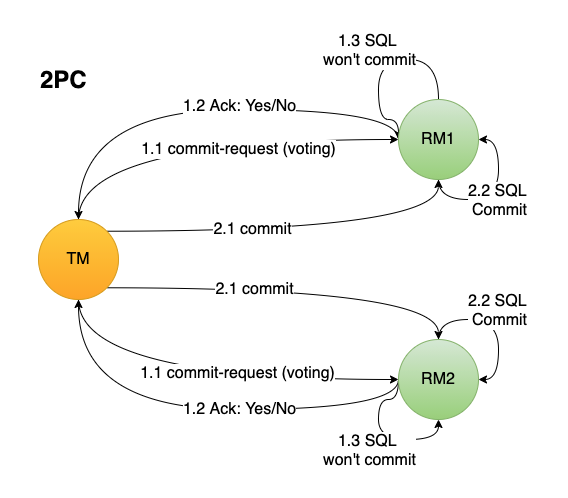

**三阶段提交 3PC**   
3PC多了一步 预提交  
也就是在预提交阶段，先使用数据库行锁或分布式锁锁定资源，准备提交。
所有参与者都预提交成功，会发送ack给协调者。  
db 数据行需要有数据状态字段，来记录数据的事务状态，以便在precommit阶段让分布式事务独占资源。

**TCC**
1. Try 准备资源
2. Confirm 都提交
3. Cancel 有参与者要求取消时，都取消。

在第二到第三阶段，可能有短暂的不一致和非原子性， 但能保证第三阶段后的最终一致性。   


## 存储引擎
| 存储引擎      | 特点                                               | 缺点                                               |
|---------------|----------------------------------------------------|----------------------------------------------------|
| **InnoDB**    | - 支持ACID事务，具有较强的事务处理能力               | - 内存占用较高，性能可能受到磁盘I/O瓶颈限制               |
|               | - 支持行级锁定，适合高并发应用                       | - 启动时恢复数据可能需要较长时间                         |
|               | - 支持外键约束和事务隔离                           | - 慢查询和复杂查询可能对性能有影响                       |
| **MyISAM**    | - 存储结构简单，读写速度较快，适合只读场景            | - 不支持事务，数据不保证一致性，容易丢失数据             |
|               | - 占用空间较小                                     | - 不支持行级锁，数据并发写入时会锁住整个表               |
|               | - 插入数据快，适合日志记录和分析                      | - 恢复机制差，不支持外键                               |
| **Memory**    | - 数据存储在内存中，读写速度极快                    | - 数据容易丢失（服务器重启时丢失）                       |
|               | - 支持哈希索引和B-tree索引                         | - 不支持事务和外键，适合缓存、临时数据存储               |
|               | - 适合做临时表和缓存用途                           | - 存储容量受限于系统内存大小                             |
| **NDB**       | - 适用于分布式架构，支持数据分片和高可用性            | - 配置复杂，调试和维护较为困难                           |
|               | - 支持自动恢复和高并发读写                           | - 性能可能不如单机引擎，尤其是在大数据量的情况下         |
| **CSV**       | - 数据存储为逗号分隔的文本文件，便于与其他工具集成    | - 性能差，适合小数据量和导出任务，不适合生产环境使用     |
|               | - 方便导出数据                                     | - 不支持索引、事务、外键等高级功能                      |
| **Archive**   | - 适合存储历史数据，压缩后存储占用空间小             | - 只支持插入和读取，不支持更新和删除                     |
|               | - 支持高效的存储和查询大量历史数据                   | - 性能差，查询较慢                                       |
| **Falcon**    | - 支持事务和MVCC，并优化了InnoDB的性能               | - 目前相对不常用，缺乏广泛的社区支持和使用               |
|               | - 支持全表扫描优化和写入优化                         | - 功能和兼容性上不如InnoDB和MyISAM                      |

Hash索引只适用于 MEMORY 引擎的表。